In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Importing the required modules

In [3]:
!pip install split-folders

In [4]:
# Module used for interacting with the file system.
import os
import json

# Modules used for data handling and manipulation
import pandas as pd
import numpy as np

# Modules used for data visualization
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.image as mpimg
import seaborn as sns
sns.set_style("whitegrid")

# Modules used for random number choice
import random as r

# Module used to split train-test split
import splitfolders

# Modules used for model training and transfer learning
import tensorflow as tf
from tensorflow.keras.layers import Dense,Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.applications as cnns
from tensorflow.keras import Model

# For graph visualization
import networkx as nx
from networkx.algorithms import bipartite

# Modules used for model evaluation and selection.
from sklearn.metrics import accuracy_score, classification_report, f1_score, recall_score, precision_score

# Module for suppressing warnings.
import warnings
warnings.filterwarnings('ignore')

# Module used for Image transformations
import scipy

# Constants
malimg_dir = "/content/drive/MyDrive/malclassfolder/malimg_dataset"
malevis_dir = "/content/drive/MyDrive/malclassfolder/malevis_dataset"

The dataset includes directories for both training and validation, each containing images of different types of malware. However, we now need to divide the training data images into separate train and test datasets to assess the performance of the models being developed. To achieve this, a class is designed to accept three inputs: the dataset directory, the percentage of images for training, and the percentage of images for testing.




Exploratory Data Analysis

In [5]:
# A class for loading an image dataset and understanding its class distribution
# and image samples across classes.
class MalwareImages:

    # Initialize the dataset loader with the dataset path.
    def __init__(self, DATA_DIR : str, n : int):
        self.DATA_DIR = DATA_DIR
        self.class_distribution = dict()
        self.ROWS = n
        self.COLS = 5
        self.ROWS = (15 + self.COLS - 1) // self.COLS

    # Computation of the class distribution of the dataset.
    def __compute_class_distribution(self):
        for malware_type in os.listdir(self.DATA_DIR):
            malware_img_dir = os.path.join(self.DATA_DIR, malware_type)
            self.class_distribution[malware_type] = len(os.listdir(malware_img_dir))

    # Plotting the class distribution.
    def plot_class_distribution(self):
        self.__compute_class_distribution()

        malware_classes = list(self.class_distribution.keys())
        malware_class_frequency = list(self.class_distribution.values())
        color_palette = sns.color_palette("pastel")
        plt.figure(figsize=(8,8))
        sns.barplot(y = malware_classes,
                    x = malware_class_frequency,
                    palette = color_palette,
                    edgecolor = "black",
                    orient='h')
        plt.title("Malware Class Distribution", fontsize=16)
        plt.xlabel("Malware Class Frequency", fontsize=14)
        plt.ylabel("Malware Type", rotation=270, labelpad=20, fontsize=14)

    # Insights into samples of different malware images across different classes.
    def malware_samples(self):
        c = 0
        fig, axs = plt.subplots(self.ROWS, self.COLS, figsize=(10, 10))

        malware_types = os.listdir(self.DATA_DIR)
        total_samples = 15  # Set the total number of samples to 15

        for malware_type in malware_types:
            malware_img_dir = os.path.join(self.DATA_DIR, malware_type)
            malware_img_samples = list(os.listdir(malware_img_dir))
            if malware_img_samples:
                malware_img_sample = r.choice(malware_img_samples)
                malware_img_sample_path = os.path.join(malware_img_dir, malware_img_sample)
                image = mpimg.imread(malware_img_sample_path)
                row = c // self.COLS
                col = c % self.COLS
                axs[row, col].imshow(image, cmap="gray")
                axs[row, col].set_title(malware_type)
                c += 1
                if c >= total_samples:
                    break

        fig.suptitle("Sample for Malware types")
        plt.subplots_adjust(wspace=0.9)
        plt.show()



MalImg Dataset


Initialization of the Dataset Loader

In [6]:
train_dataset = MalwareImages(os.path.join(malimg_dir, "train"),
                              5)


Class Distribution

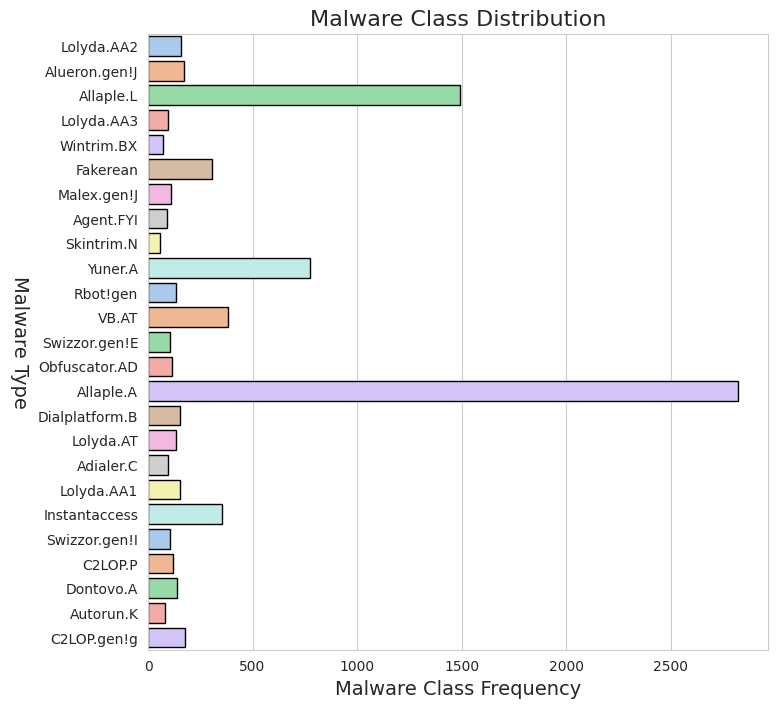

In [7]:
train_dataset.plot_class_distribution()

Malware Image Samples

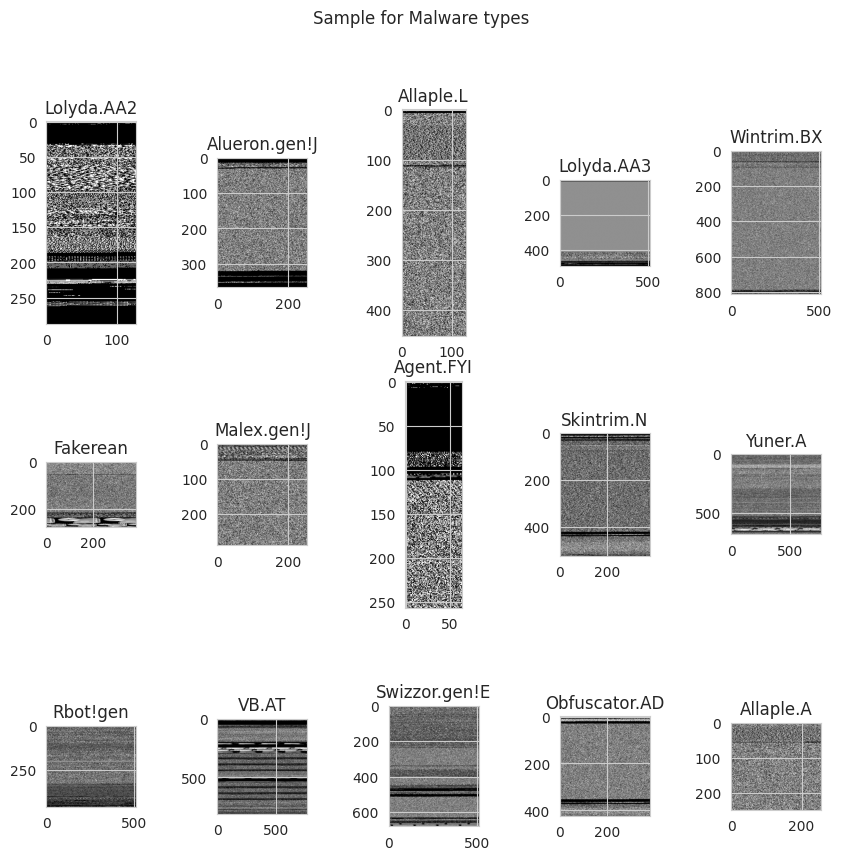

In [8]:
train_dataset.malware_samples()



Malevis Image Dataset

Initialization of the dataset loader

In [9]:
train_dataset_malevis = MalwareImages(os.path.join(malevis_dir, "train"),
                                      6)

Class Distribution

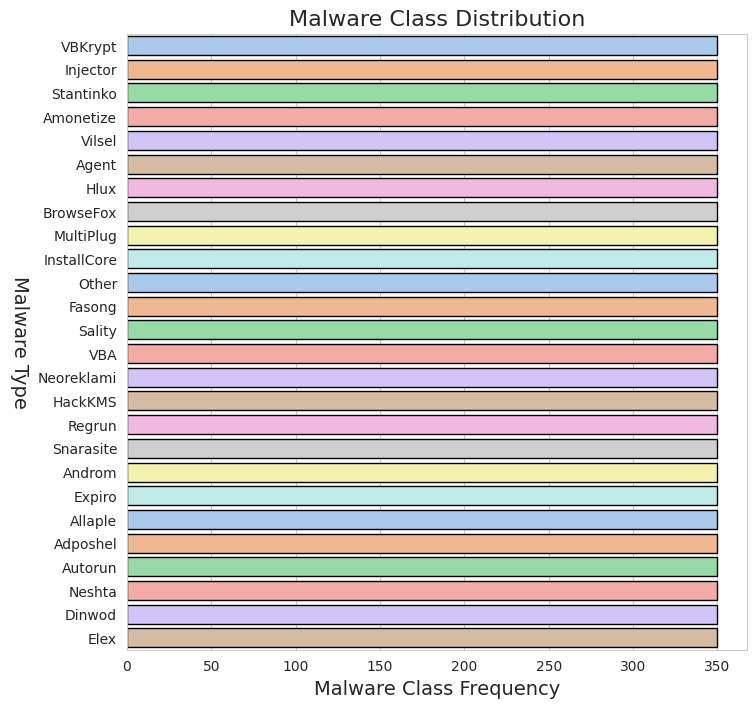

In [10]:
train_dataset_malevis.plot_class_distribution()


Malware Image Samples

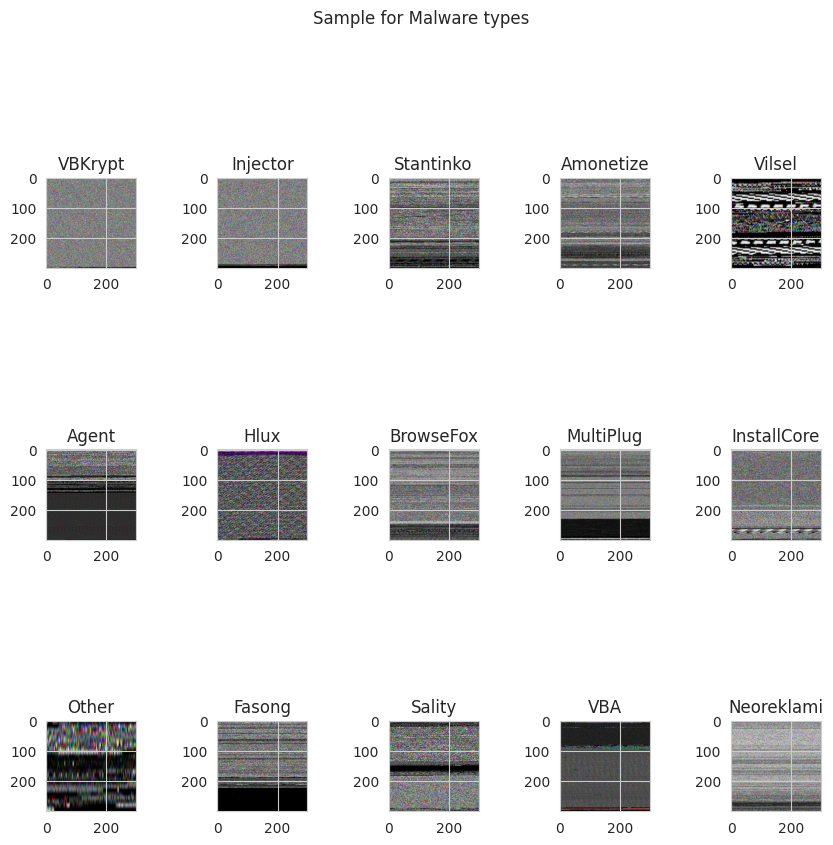

In [11]:
train_dataset_malevis.malware_samples()

Train-Test Split

In [12]:
# Splitting the dataset into training and testing subsets proportionally.
def split_dataset(train_data_dir : str, dest_path : str, train_ratio : float, test_ratio : float):

    splitfolders.ratio(input = train_data_dir,
                       output = dest_path,
                       seed = 1337,
                       ratio = (train_ratio, 0, test_ratio),
                       group_prefix = None,
                       move = False)

Malimg Dataset

In [13]:
split_dataset(os.path.join(malimg_dir,
                           "train"),
              "malimg/",
              0.8,
              0.2)

Copying files: 8404 files [07:57, 17.60 files/s]


Malevis Dataset

In [14]:
split_dataset(os.path.join(malevis_dir,
                           "train"),
              "malevis/",
              0.8,
              0.2)

Copying files: 9100 files [03:22, 44.84 files/s] 


Image Preprocessing

In [15]:
# A class to preprocess the malware images to make it usable for training neural networks.
class ImageProcessor:

    # Initialization of the image preprocessor with required file locations.
    def __init__(self, model, train_dir : str, test_dir : str, val_dir : str, size, colormode : str) -> None:
        self.cnn_variant = model
        self.train_gen = None
        self.test_gen = None
        self.val_gen = None
        self.colormode = colormode
        self.TRAIN_DIR = train_dir
        self.TEST_DIR = test_dir
        self.VAL_DIR = val_dir
        self.size = size

    # Creating generators based on the preprocessing requirements of the CNN architecture.
    def create_generators(self):
        self.train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input,
        )

        self.test_gen = tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

        self.val_gen =  tf.keras.preprocessing.image.ImageDataGenerator(
            preprocessing_function=self.cnn_variant.preprocess_input
        )

    # Reading the images from the respective directories.
    def get_images(self):
        train_images = self.train_gen.flow_from_directory(
            directory=self.TRAIN_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42,
            subset='training',
        )

        val_images = self.val_gen.flow_from_directory(
            directory=self.VAL_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=True,
            seed=42
        )

        test_images = self.test_gen.flow_from_directory(
            directory=self.TEST_DIR,
            target_size=self.size,
            classes=sorted([i for i in os.listdir(self.TRAIN_DIR) if i != "Other"]),
            color_mode=self.colormode,
            class_mode='categorical',
            batch_size=32,
            shuffle=False,
            seed=42
        )

        return train_images, val_images, test_images

Domain Adaptation of CNN architectures

In [16]:
# A class to adapt the state of the art CNNs
# for the classification of malware images.
class FineTuning:

    # Initialization of the Domain Adaptation process with required parameters.
    def __init__(self, train, val, model, class_count : int, regularize : bool, patience : int) -> None:
        self.train = train
        self.val = val
        self.model = model
        self.history = None
        self.fine_tune_from = 100
        self.CLASSES = class_count
        self.regularize = regularize
        self.patience = patience

    # Marking layers trainable or not.
    def fine_tune(self):
        for layer in self.model.layers[:self.fine_tune_from]:
            layer.trainable = False

        for layer in self.model.layers[self.fine_tune_from:]:
            layer.trainable = True

    # Addition of the final layer to the model with or without regularization.
    def add_final_layer(self):
        self.x = Flatten()(self.model.output)
        if self.regularize == True:
            self.x = Dense(2000, activation='relu')(self.x)
            self.x = Dropout(0.6)(self.x)
            self.x = Dense(1400, activation='relu')(self.x)
            self.x = Dropout(0.5)(self.x)
        self.x = Dense(1000, activation='relu')(self.x)
        self.predictions = Dense(self.CLASSES, activation = 'softmax')(self.x)

    # Compilation of the model with all the metrics, optimizer, and loss functions.
    def compile_model(self):
        self.model = Model(inputs = self.model.input, outputs = self.predictions)
        self.model.compile(optimizer='adam', loss="categorical_crossentropy",
                           metrics=['accuracy',
                                    tf.keras.metrics.AUC(name="auc",from_logits=True),
                                    tf.keras.metrics.FalsePositives(name="false_positives"),
                                    tf.keras.metrics.Precision(name="precision"),
                                    tf.keras.metrics.Recall(name="recall")])

    # Training the model with Early Stopping Criterion
    # on Validation Loss.
    def train_model(self):
        self.history = self.model.fit(self.train,
                                      batch_size=32,
                                      epochs=80,
                                      validation_data=self.val,
                                      callbacks=[
                                        tf.keras.callbacks.EarlyStopping(
                                            monitor='val_loss',
                                            patience=self.patience,
                                            restore_best_weights=True
                                        )
                                     ])

Experimentation of CNN architecture using Domain Adaptation


In [17]:
# Experimentation of a CNN architecture on the datasets using Domain Adaptation.
def experiment_model(preprocess_fx, new_data_dir : str,orig_data_dir : str, size, model, nclasses : int, val_dir : str, regularize : bool, patience : int):
    # Preprocessing the images.
    img = ImageProcessor(preprocess_fx,
                     os.path.join(new_data_dir, "train"),
                     os.path.join(new_data_dir, "test"),
                     os.path.join(orig_data_dir, val_dir),
                     size,
                     "rgb")
    img.create_generators()
    train, val, test = img.get_images()

    # Domain Adaptation of the CNN architecture.
    learner = FineTuning(train, val,
                         model, nclasses,
                         regularize, patience)
    learner.fine_tune()
    learner.add_final_layer()
    learner.compile_model()
    learner.train_model()

    # Returning the model, its training history, and
    # preprocessed test data for model evaluation.
    return learner.model, learner.history, test


Model Evaluation

In [18]:
# A class for the evaluating any Multiclass Classifier.
class ModelEvaluator:

    # Initialization of the evaluator with the model,
    # its training history, and preprocessed test data.
    def __init__(self, history, classes : list, model, test):
        self.history = history
        self.model = model
        self.test = test
        self.classes = classes
        self.num_classes = len(self.classes)
        self.predictions = None

    # Plotting the comparison of the performance on train and validation data.
    # based on a particular metric.
    def __plot_metric(self, ax, metric: str,train_metric : str, val_metric : str):

        ax.plot(self.history.history[train_metric])
        ax.plot(self.history.history[val_metric])


        ax.set_xlabel('Epochs')
        ax.set_ylabel(metric.title())
        ax.legend(['Train','Val'])

    # Plotting the overall training history.
    def training_history(self):
        rows = 2
        columns = 1
        c = 0
        metrics = ["accuracy", "loss"]

        fig, axs = plt.subplots(rows, columns,figsize=(10,10))
        for metric in metrics:
            self.__plot_metric(axs[c],
                               metric.replace("_", " ").title(),
                               metric, "val_"+metric)
            c += 1

        fig.suptitle("Training History of the Model")
        plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.5)
        plt.show()

    # Fetching the predictions from the model and its post processing.
    def predict(self):
        self.predictions = self.model.predict(self.test)
        self.predictions = list(map(np.argmax, self.predictions))

    # Displaying the classification report and Confusion Matrix.
    def class_report(self):
        plt.figure(figsize=(10,10))
        sns.heatmap(tf.math.confusion_matrix(self.test.labels, self.predictions, num_classes=len(self.classes)),
                    annot=False, cmap="crest" , cbar=False)
        plt.xlabel("Predicted Label", fontsize=16)
        plt.ylabel("True Label", fontsize=16)
        plt.xticks(fontsize=14)
        plt.yticks(fontsize=14)


        plt.show()

        print(classification_report(self.test.labels, self.predictions, target_names=self.classes))

Model Exploration on the two datasets

In [19]:
malimg_models = dict()
malevis_models = dict()

# **MobileNetV2**

Malimg Dataset

Model Training

In [20]:
import scipy

model, history, test = experiment_model(cnns.mobilenet,
                                        "malimg",
                                        malimg_dir,
                                        (75, 75),
                                        cnns.MobileNetV2(include_top=False,
                                                      input_shape=(75, 75, 3)),
                                        25, "validation",
                                        False, 3)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 6711 images belonging to 25 classes.
Found 910 images belonging to 25 classes.
Found 1693 images belonging to 25 classes.
Epoch 1/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 455s 2s/step - accuracy: 0.6376 - auc: 0.9275 - false_positives: 704.6777 - loss: 1.7458 - precision: 0.7079 - recall: 0.5637 - val_accuracy: 0.1780 - val_auc: 0.6099 - val_false_positives: 730.0000 - val_loss: 24.0632 - val_precision: 0.1807 - val_recall: 0.1769
Epoch 2/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 21s 99ms/step - accuracy: 0.8333 - auc: 0.9906 - false_positives: 475.6682 - loss: 0.4710 - precision: 0.8544 - recall: 0.8129 - val_accuracy: 0.1165 - val_auc: 0.5600 - val_false_positives: 717.0000 - val_loss: 7.8750 - val_precision: 0.1224 - val_recall: 0.1099
Epoch 3/80
210/210 ━━━━━━━━━━━━━━━━━━━━ 42s 102ms/step - accuracy: 0.8213 - auc: 0.9874 - false_positives: 506.0474 - loss: 0.5244 - precision: 0.8383 - recall: 0.8028 - val_accuracy: 0.1923 - val_auc: 0.6107 - val_

Model Evaluation

Initialization of evaluator

In [21]:
me = ModelEvaluator(history,
                    list(test.class_indices.keys()),
                    model, test)


Training History

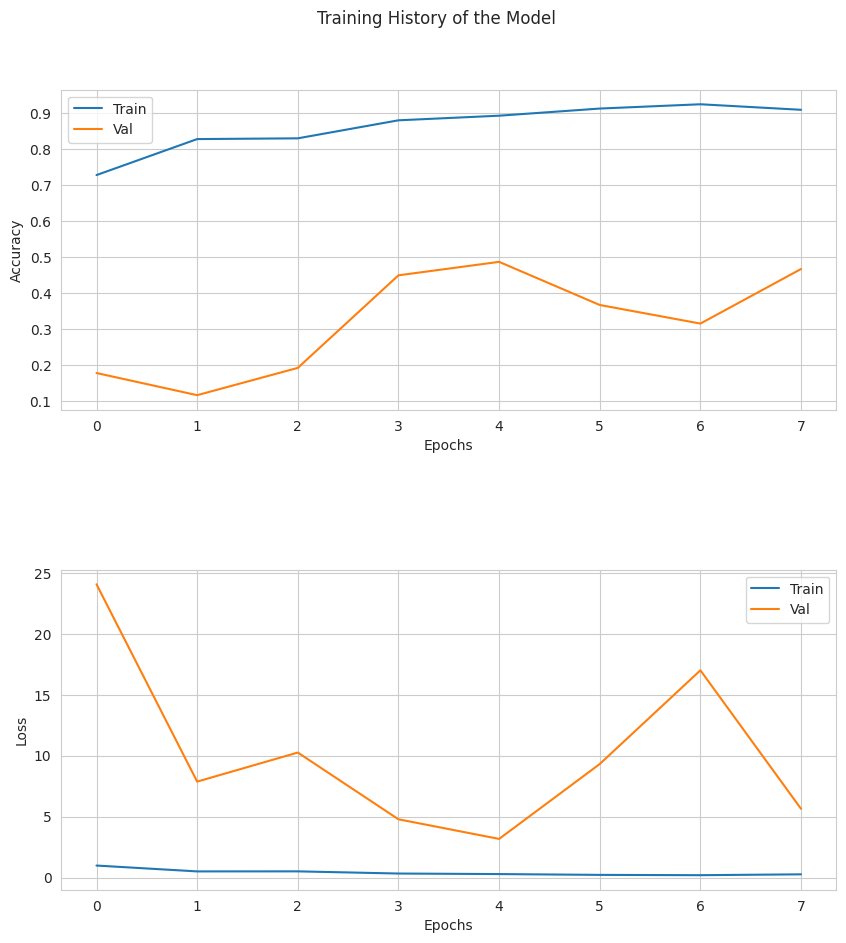

In [22]:
me.training_history()

Classification Metrics

53/53 ━━━━━━━━━━━━━━━━━━━━ 14s 200ms/step


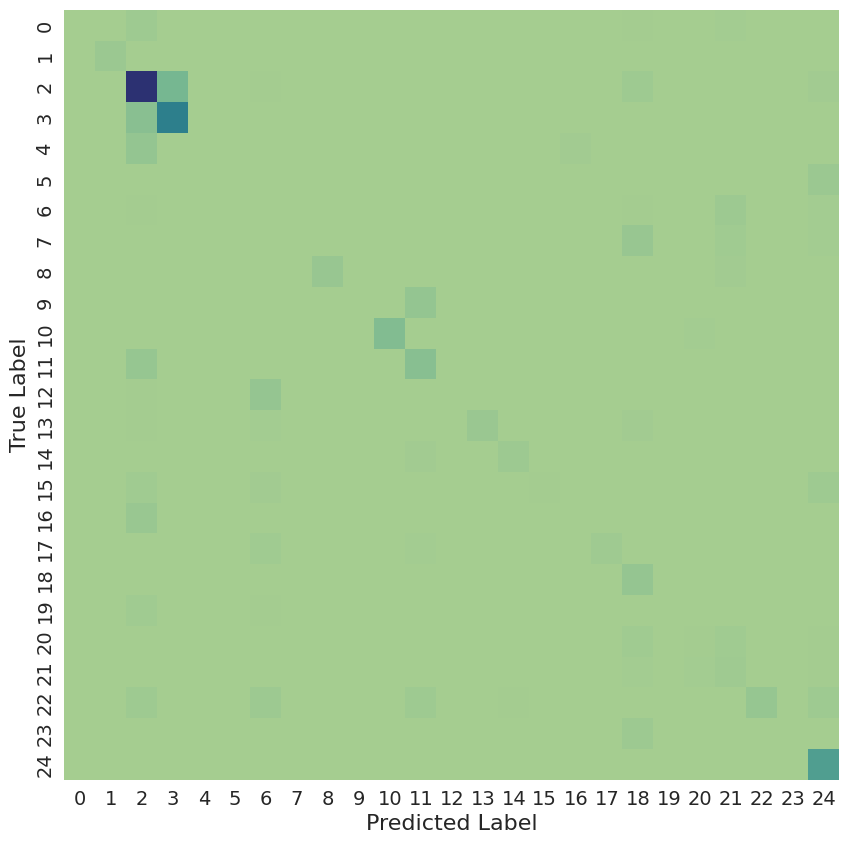

                precision    recall  f1-score   support

     Adialer.C       0.00      0.00      0.00        20
     Agent.FYI       1.00      0.95      0.97        19
     Allaple.A       0.74      0.82      0.78       565
     Allaple.L       0.76      0.85      0.80       299
 Alueron.gen!J       0.00      0.00      0.00        35
     Autorun.K       0.00      0.00      0.00        17
       C2LOP.P       0.02      0.04      0.02        25
   C2LOP.gen!g       0.00      0.00      0.00        35
Dialplatform.B       1.00      0.74      0.85        31
     Dontovo.A       0.00      0.00      0.00        28
      Fakerean       1.00      0.92      0.96        62
 Instantaccess       0.49      0.67      0.56        72
    Lolyda.AA1       0.00      0.00      0.00        31
    Lolyda.AA2       1.00      0.59      0.75        32
    Lolyda.AA3       0.81      0.65      0.72        20
     Lolyda.AT       1.00      0.07      0.14        27
   Malex.gen!J       0.00      0.00      0.00  

In [23]:
me.predict()
me.class_report()

# Malevis **Dataset**


Model training

In [25]:
model, history, test = experiment_model(cnns.mobilenet,
                                        "malevis",malevis_dir,
                                        (200, 200),
                                        cnns.MobileNetV2(include_top=False,
                                                      input_shape=(200, 200, 3)),
                                        25, "val",
                                        False, 8)

Found 7000 images belonging to 25 classes.
Found 3644 images belonging to 25 classes.
Found 1750 images belonging to 25 classes.
Epoch 1/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 110s 396ms/step - accuracy: 0.6402 - auc: 0.8961 - false_positives: 436.3546 - loss: 3.1565 - precision: 0.7798 - recall: 0.5477 - val_accuracy: 0.0401 - val_auc: 0.4998 - val_false_positives: 3498.0000 - val_loss: 115.2871 - val_precision: 0.0401 - val_recall: 0.0401
Epoch 2/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 68s 311ms/step - accuracy: 0.8520 - auc: 0.9785 - false_positives: 288.6364 - loss: 0.8815 - precision: 0.9109 - recall: 0.8187 - val_accuracy: 0.0359 - val_auc: 0.5079 - val_false_positives: 3512.0000 - val_loss: 91.3633 - val_precision: 0.0360 - val_recall: 0.0359
Epoch 3/80
219/219 ━━━━━━━━━━━━━━━━━━━━ 49s 224ms/step - accuracy: 0.8738 - auc: 0.9849 - false_positives: 243.4545 - loss: 0.6746 - precision: 0.9244 - recall: 0.8438 - val_accuracy: 0.0412 - val_auc: 0.4994 - val_false_positives: 3493.0000 - val_loss: 6

Model Evaluation

Initialization of Evaluator

In [26]:
me = ModelEvaluator(history,
                    list(test.class_indices.keys()),
                    model, test)

Training History

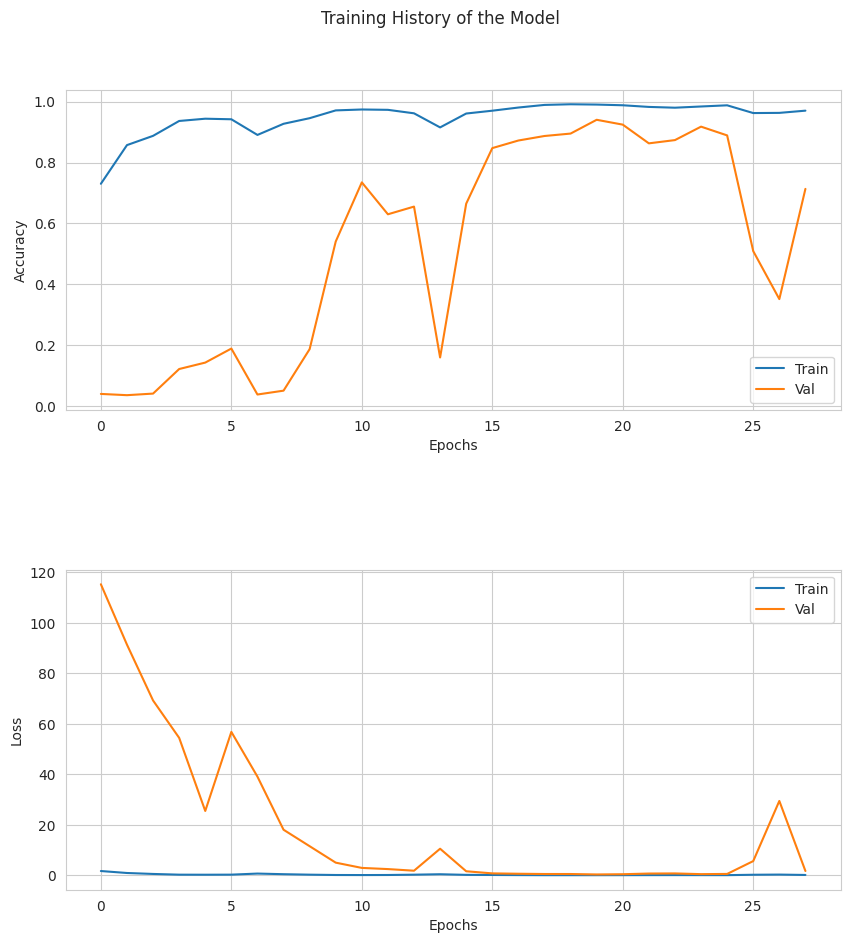

In [27]:
me.training_history()

Classification Metrics

55/55 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step


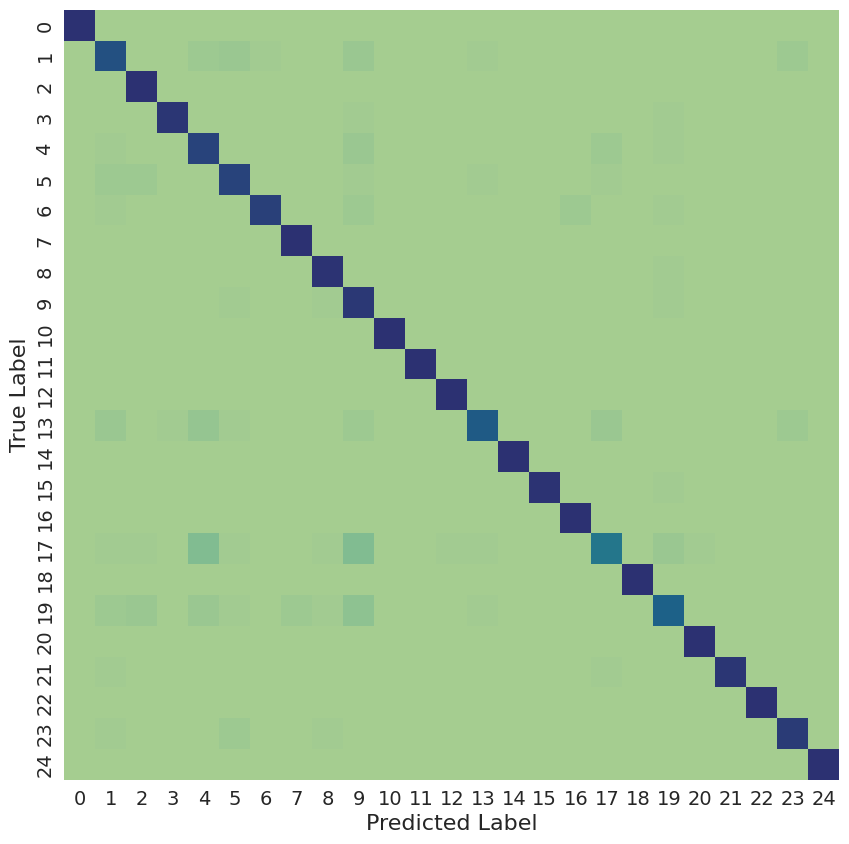

              precision    recall  f1-score   support

    Adposhel       1.00      1.00      1.00        70
       Agent       0.83      0.83      0.83        70
     Allaple       0.92      1.00      0.96        70
   Amonetize       0.99      0.97      0.98        70
      Androm       0.78      0.90      0.83        70
     Autorun       0.88      0.90      0.89        70
   BrowseFox       0.98      0.91      0.95        70
      Dinwod       0.97      1.00      0.99        70
        Elex       0.95      0.99      0.97        70
      Expiro       0.71      0.96      0.82        70
      Fasong       1.00      1.00      1.00        70
     HackKMS       1.00      1.00      1.00        70
        Hlux       0.99      1.00      0.99        70
    Injector       0.93      0.77      0.84        70
 InstallCore       1.00      1.00      1.00        70
   MultiPlug       1.00      0.99      0.99        70
  Neoreklami       0.97      1.00      0.99        70
      Neshta       0.86    

In [28]:
me.predict()
me.class_report()